# Bird Species Classification:
### Using Computer Vision to Classify 525 Different Bird Species

##### By: David Hartsman

<hr style="border: 2px solid blue">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras

import datetime
import os

from tqdm import tqdm

from pathlib import Path

# To streamline the naming and generate tabular image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras model types and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

# Metrics for classification
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives

2024-02-05 11:31:30.957483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<hr style="border: 2px solid blue">

### Data Inspection

In [2]:
df = pd.read_csv('/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/birds.csv')

In [3]:
df.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [4]:
# Almost 90k images
df.shape

(89885, 5)

In [5]:
# There is a 2 - to - 1 ratio of max class observations to min class observations
df["class id"].value_counts()

class id
426.0    273
286.0    258
181.0    243
367.0    243
40.0     230
        ... 
357.0    140
445.0    140
375.0    140
211.0    140
408.0    140
Name: count, Length: 525, dtype: int64

<hr style="border: 2px solid blue">

In [14]:
# Using os library to access the files in the "train" path

path = "/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive"

print(os.listdir(os.path.join(path, "train"))[:5])

['CREAM COLORED WOODPECKER', 'CAMPO FLICKER', 'RUFUOS MOTMOT', 'WHITE TAILED TROPIC', 'KOOKABURRA']


<hr style="border: 2px solid blue">

### Video Tutorial Method: seems to be the same as the ImageDataGenerator

In [44]:
# Maintaining the initial pixel shape and setting a random seed for reproduceability

data = tf.keras.utils.image_dataset_from_directory(os.path.join(path, "train"), image_size=(224,224), seed=13)

Found 84635 files belonging to 525 classes.


In [45]:
# Creating a numpy iterator to build the array

data_iterator = data.as_numpy_iterator()

In [80]:
# Creating the dictionary for the class labels potentially for later use

label_dict = {i:idx for idx, i in enumerate(data.class_names)}

In [82]:
label_dict == class_indices

True

In [46]:
batch = data_iterator.next()

In [49]:
batch[1][:4]

array([403, 520, 261, 511], dtype=int32)

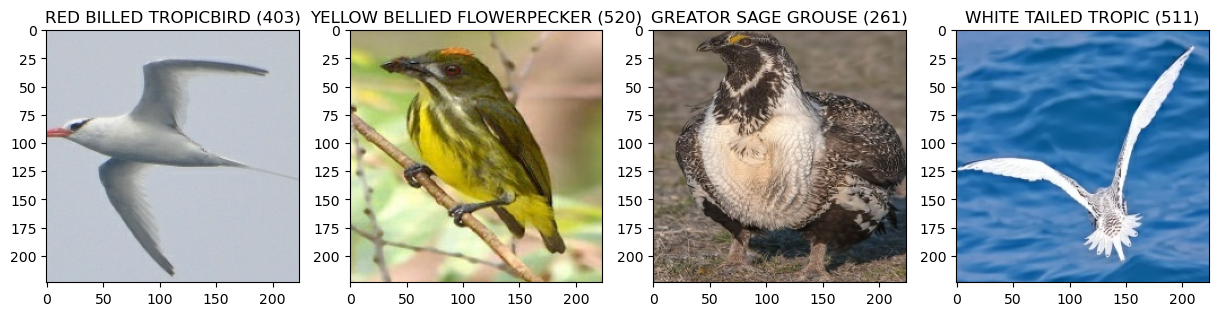

In [78]:
fig, ax = plt.subplots(ncols=4, figsize=(15,5))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    title = reverse_dict[batch[1][idx]]
    ax[idx].set_title(f"{title} ({batch[1][idx]})")

In [66]:
for key, val in class_indices.items():
    if class_indices[key] == 261:
        print(key)

GREATOR SAGE GROUSE


In [68]:
reverse_dict = {val:key for key, val in class_indices.items()} 
reverse_dict

{0: 'ABBOTTS BABBLER',
 1: 'ABBOTTS BOOBY',
 2: 'ABYSSINIAN GROUND HORNBILL',
 3: 'AFRICAN CROWNED CRANE',
 4: 'AFRICAN EMERALD CUCKOO',
 5: 'AFRICAN FIREFINCH',
 6: 'AFRICAN OYSTER CATCHER',
 7: 'AFRICAN PIED HORNBILL',
 8: 'AFRICAN PYGMY GOOSE',
 9: 'ALBATROSS',
 10: 'ALBERTS TOWHEE',
 11: 'ALEXANDRINE PARAKEET',
 12: 'ALPINE CHOUGH',
 13: 'ALTAMIRA YELLOWTHROAT',
 14: 'AMERICAN AVOCET',
 15: 'AMERICAN BITTERN',
 16: 'AMERICAN COOT',
 17: 'AMERICAN DIPPER',
 18: 'AMERICAN FLAMINGO',
 19: 'AMERICAN GOLDFINCH',
 20: 'AMERICAN KESTREL',
 21: 'AMERICAN PIPIT',
 22: 'AMERICAN REDSTART',
 23: 'AMERICAN ROBIN',
 24: 'AMERICAN WIGEON',
 25: 'AMETHYST WOODSTAR',
 26: 'ANDEAN GOOSE',
 27: 'ANDEAN LAPWING',
 28: 'ANDEAN SISKIN',
 29: 'ANHINGA',
 30: 'ANIANIAU',
 31: 'ANNAS HUMMINGBIRD',
 32: 'ANTBIRD',
 33: 'ANTILLEAN EUPHONIA',
 34: 'APAPANE',
 35: 'APOSTLEBIRD',
 36: 'ARARIPE MANAKIN',
 37: 'ASHY STORM PETREL',
 38: 'ASHY THRUSHBIRD',
 39: 'ASIAN CRESTED IBIS',
 40: 'ASIAN DOLLARD BIRD',
 41:

In [83]:
batch[0].shape

(32, 224, 224, 3)

### Scaling the data within the data pipeline

In [90]:
# Re-initiating the data object

data = tf.keras.utils.image_dataset_from_directory(os.path.join(path, "train"), image_size=(224,224), seed=13)
data = data.map(lambda x, y: (x/255, y))

Found 84635 files belonging to 525 classes.


In [91]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [92]:
# Confirmation of scaling success

batch[0].min(), batch[0].max()

(0.0, 1.0)

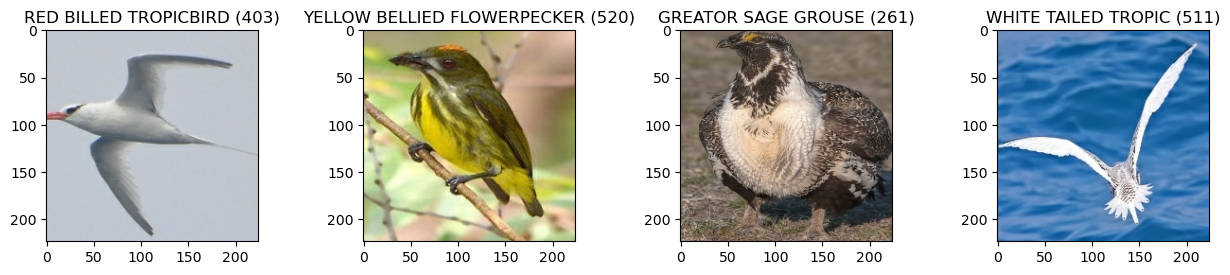

In [94]:
# Same plot with scaled data, however increasing the space between plots with gridspec_kw argument
fig, ax = plt.subplots(ncols=4, figsize=(15,5), gridspec_kw={"wspace":.5})
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    title = reverse_dict[batch[1][idx]]
    ax[idx].set_title(f"{title} ({batch[1][idx]})")

<hr style="border: 2px solid blue">


### Splitting Data
The kaggle competition has pre-split images into train, validation, and test sets. Therefore the process of splitting our data should be extremely easy.

In [95]:
# Splitting the data using the same process

# Training
train_data = tf.keras.utils.image_dataset_from_directory(os.path.join(path, "train"), image_size=(224,224), seed=13)
train_data = data.map(lambda x, y: (x/255, y))

# Validation
valid_data = tf.keras.utils.image_dataset_from_directory(os.path.join(path, "valid"), image_size=(224,224), seed=13)
valid_data = data.map(lambda x, y: (x/255, y))

# Test
test_data = tf.keras.utils.image_dataset_from_directory(os.path.join(path, "test"), image_size=(224,224), seed=13)
test_data = data.map(lambda x, y: (x/255, y))

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


<hr style="border: 2px solid blue">


### Model Creation

In [101]:
# Instantiation
model = Sequential()

# First convolutional layer, then max pooling 
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D()) # condenses information over a set region - (2,2) default - returns the max of the region

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

# creates a 1 Dimensional tensor shape of (x, 1)
model.add(Flatten())

model.add(Dense(224, activation="relu"))
model.add(Dense(525, activation="softmax"))

In [102]:
# Model Compilation

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [103]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 16)      

In [106]:
# Flatten Layer Output Shape

26 * 26 * 16

10816

In [107]:
logdir = "logs"

In [109]:
# Callback for tracking model training

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(path, logdir))

In [110]:
# Fitting the model

hist = model.fit(train_data, epochs=5, validation_data=valid_data, callbacks=[tensorboard_callback])

Epoch 1/5


ValueError: in user code:

    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 525) are incompatible


### Using Tensorflow's ImageDataGenerator

In [111]:
from keras.preprocessing.image import ImageDataGenerator

# Define the main directory containing subdirectories for each bird species
main_directory = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/train'

# Define data augmentation and normalization options
image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Generate batches of augmented data from images in the directory
data_generator = image_generator.flow_from_directory(
    main_directory,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical'  # Use categorical labels
)

Found 84635 images belonging to 525 classes.


In [112]:
# Check the class indices (corresponding to bird species labels)

# Returns a dictionary of string:numeric_code for the class labels
class_indices = data_generator.class_indices

# Print type, first 5 keys
print(type(class_indices))
print("Class indices:", list(class_indices.keys())[:5])

<class 'dict'>
Class indices: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO']


In [114]:
valid_generator = image_generator.flow_from_directory(
    os.path.join(path, "valid"),
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical'  # Use categorical labels
)

test_generator = image_generator.flow_from_directory(
    os.path.join(path, "test"),
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical')  # Use categorical labels

Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


### Model Creation

In [116]:
# Instantiation
model = Sequential()

# First convolutional layer, then max pooling 
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D()) # condenses information over a set region - (2,2) default - returns the max of the region

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

# creates a 1 Dimensional tensor shape of (x, 1)
model.add(Flatten())

model.add(Dense(224, activation="relu"))
model.add(Dense(525, activation="softmax"))

In [117]:
# Model Compilation

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [118]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 16)      

In [ ]:
logdir = "logs"

In [120]:
# Callback for tracking model training

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(path, logdir))

In [ ]:
# Fitting the model 1 Epoch takes about 10 minutes

hist = model.fit(data_generator, epochs=20, validation_data=valid_generator, callbacks=[tensorboard_callback],\
                 workers=6, use_multiprocessing=True)

Epoch 1/20


Exception in thread Thread-171 (_run):
Traceback (most recent call last):
  File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/utils/data_utils.py", line 777, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/keras/utils/data_utils.py", line 752, in pool_fn
    pool = get_pool_class(True)(
  File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/multiprocessing/context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/multiprocessing/pool.py

In [45]:
from keras.preprocessing.image import ImageDataGenerator

# Define the main directory containing subdirectories for each bird species
main_directory = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/birds_archive/train'

# Define data augmentation and normalization options
image_generator = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Generate batches of augmented data from images in the directory
data_generator = image_generator.flow_from_directory(
    main_directory,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,  # Define batch size
    class_mode='categorical'  # Use categorical labels
)

# Check the class indices (corresponding to bird species labels)
class_indices = data_generator.class_indices
print("Class indices:", class_indices)

# Accessing batch data and labels
for images, labels in data_generator:
    # images: a batch of input images (shape: (batch_size, 224, 224, 3))
    # labels: a batch of corresponding labels (shape: (batch_size, num_classes))
    # Process each batch of data here
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break  # Exit the loop after processing the first batch

Found 84635 images belonging to 525 classes.
Class indices: {'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'AFRICAN PIED HORNBILL': 7, 'AFRICAN PYGMY GOOSE': 8, 'ALBATROSS': 9, 'ALBERTS TOWHEE': 10, 'ALEXANDRINE PARAKEET': 11, 'ALPINE CHOUGH': 12, 'ALTAMIRA YELLOWTHROAT': 13, 'AMERICAN AVOCET': 14, 'AMERICAN BITTERN': 15, 'AMERICAN COOT': 16, 'AMERICAN DIPPER': 17, 'AMERICAN FLAMINGO': 18, 'AMERICAN GOLDFINCH': 19, 'AMERICAN KESTREL': 20, 'AMERICAN PIPIT': 21, 'AMERICAN REDSTART': 22, 'AMERICAN ROBIN': 23, 'AMERICAN WIGEON': 24, 'AMETHYST WOODSTAR': 25, 'ANDEAN GOOSE': 26, 'ANDEAN LAPWING': 27, 'ANDEAN SISKIN': 28, 'ANHINGA': 29, 'ANIANIAU': 30, 'ANNAS HUMMINGBIRD': 31, 'ANTBIRD': 32, 'ANTILLEAN EUPHONIA': 33, 'APAPANE': 34, 'APOSTLEBIRD': 35, 'ARARIPE MANAKIN': 36, 'ASHY STORM PETREL': 37, 'ASHY THRUSHBIRD': 38, 'ASIAN CRESTED IBIS': 39, 'ASIAN DOL

Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32, 525)


In [51]:
# Initialize lists to store images and labels
images_list = []
labels_list = []

# Iterate over the data iterator to process batches of data
for images, labels in tqdm(data_generator):
    # Append images and labels from the current batch to the lists
    images_list.append(images)
    labels_list.append(labels)
    
    if len(images_list) * images.shape[0] >= len(data_generator.filenames):
        break

100%|█████████████████████████████████████████████████████████████████████████████████▉| 2644/2645 [19:25<00:00,  2.27it/s]


In [ ]:
# Concatenate the lists of images and labels into NumPy arrays
images_array = np.concatenate(images_list, axis=0)
# labels_array = np.concatenate(labels_list, axis=0)

NameError: name 'images_list' is not defined